# Journal Profiling Part 4: Institutions

This Python notebook shows how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) to extract information about the authors affiliations data linked to [publications](https://docs.dimensions.ai/dsl/datasource-publications.html) of a specific journal.

This tutorial is the fourth of a series that uses the data extracted in order to generate a 'journal profile' report. See the [API Lab homepage](https://api-lab.dimensions.ai/) for the other tutorials in this series.

In this notebook we are going to 

* Load the publications data extracted in part 1
* Focus on institutions linked to a journal: measure how often do they appear, how many affiliated authors they have etc..
* Build some simple visualizations in order to have a quick overview of the results 

## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the *Getting Started* tutorial.


In [1]:
!pip install dimcli plotly tqdm -U --quiet 

import dimcli
from dimcli.utils import *
import os, sys, time, json
from tqdm.notebook import tqdm as progress
import pandas as pd
import plotly.express as px
from plotly.offline import plot
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)

print("==\nLogging in..")
# https://digital-science.github.io/dimcli/getting-started.html#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  KEY = getpass.getpass(prompt='API Key: ')  
  dimcli.login(KEY, ENDPOINT)
else:
  KEY = ""
  dimcli.login(KEY, ENDPOINT)
dsl = dimcli.Dsl()

==
Logging in..
Dimcli - Dimensions API Client (v0.8.2)
Connected to: https://app.dimensions.ai - DSL v1.28
Method: dsl.ini file


Finally, let's set up a folder to store the data we are going to extract: 

In [2]:
# create output data folder
FOLDER_NAME = "journal-profile-data"
if not(os.path.exists(FOLDER_NAME)):
    os.mkdir(FOLDER_NAME)

def save(df,filename_dot_csv):
    df.to_csv(FOLDER_NAME+"/"+filename_dot_csv, index=False)

## Institutions Contributing to a Journal

From our original publications dataset, we now want to look at institutions i.e. 

* getting the full list of institutions (also ones without a GRID, for subsequent analysis) linked to the journal
* publications count 
* authors count 

#### Load previously saved affiliations data
Let's reload the affiliations data from Part-1 of this tutorial series.

**NOTE** If you are using Google Colab or don't have the data available, just do the following: 
* open up the 'Files' panel in Google Colab and create a new folder `journal-profile-data`
* grab this [file](https://github.com/digital-science/dimensions-api-lab/tree/master/cookbooks/2-publications/journal-profile-data.zip), unzip it, open the enclosed folder and upload the file called `1_publications_affiliations.csv` to Google Colab ('Upload' menu or also by dragging then inside the panel window)
* move the file inside the `journal-profile-data` folder you just created 

In [3]:
affiliations = pd.read_csv(FOLDER_NAME+"/1_publications_affiliations.csv")
affiliations.head(10)

,aff_id,aff_name,aff_city,aff_city_id,aff_country,aff_country_code,aff_state,aff_state_code,pub_id,researcher_id,first_name,last_name
0,grid.51462.34,Memorial Sloan Kettering Cancer Center,New York,5128581.0,United States,US,New York,US-NY,pub.1130757641,NaN,Anton G.,Henssen
1,grid.6363.0,Charité,Berlin,2950159.0,Germany,DE,NaN,NaN,pub.1130757641,NaN,Anton G.,Henssen
2,grid.51462.34,Memorial Sloan Kettering Cancer Center,New York,5128581.0,United States,US,New York,US-NY,pub.1130757641,NaN,Richard,Koche
3,grid.168645.8,University of Massachusetts Medical School,Worcester,4956184.0,United States,US,Massachusetts,US-MA,pub.1130757641,NaN,Jiali,Zhuang
4,grid.51462.34,Memorial Sloan Kettering Cancer Center,New York,5128581.0,United States,US,New York,US-NY,pub.1130757641,NaN,Eileen,Jiang
5,grid.51462.34,Memorial Sloan Kettering Cancer Center,New York,5128581.0,United States,US,New York,US-NY,pub.1130757641,NaN,Casie,Reed
6,grid.51462.34,Memorial Sloan Kettering Cancer Center,New York,5128581.0,United States,US,New York,US-NY,pub.1130757641,NaN,Amy,Eisenberg
7,grid.51462.34,Memorial Sloan Kettering Cancer Center,New York,5128581.0,United States,US,New York,US-NY,pub.1130757641,NaN,Eric,Still
8,grid.51462.34,Memorial Sloan Kettering Cancer Center,New York,5128581.0,United States,US,New York,US-NY,pub.1130757641,NaN,Ian C.,MacArthur
9,grid.10097.3f,Barcelona Supercomputing Center,Barcelona,3128760.0,Spain,ES,NaN,NaN,pub.1130757641,NaN,Elias,Rodríguez-Fos


## Basic stats about affiliations

* count how many affiliations statements in total
* count how many affiliations have a GRID ID
* count how many unique GRID IDs we have in total

In [4]:
#
# segment the affiliations dataset
affiliations = affiliations.fillna('') 
affiliations_with_grid = affiliations.query("aff_id != ''")
affiliations_without_grid = affiliations.query("aff_id == ''")
#
# save
save(affiliations_without_grid, "4_institutions_without_grid.csv")

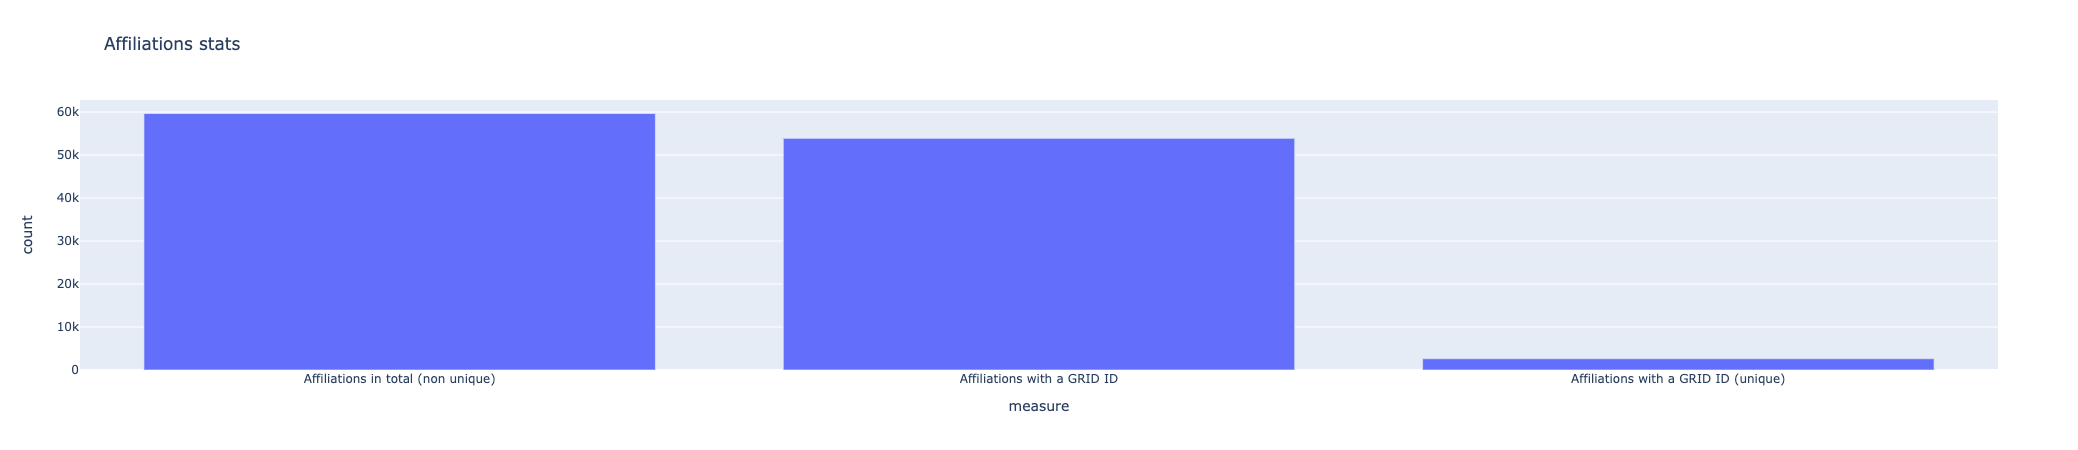

In [5]:
# build a summary barchart

df = pd.DataFrame({
    'measure' : ['Affiliations in total (non unique)', 'Affiliations with a GRID ID', 'Affiliations with a GRID ID (unique)'],
    'count' : [len(affiliations), len(affiliations_with_grid), affiliations_with_grid['aff_id'].nunique()],
})
px.bar(df, x="measure", y="count", title=f"Affiliations stats")

## Enriching the unique affiliations (GRIDs list) with pubs count and authors count

We want a table with the following columns 

* grid ID
* city
* country
* country code
* name
* tot_pubs
* tot_affiliations

NOTE: tot_affiliations is a list of 'authorships' (ie authors in the context of each publication). 

For out analysis we can start from the `gridaffiliations` dataframe. 

In [6]:
affiliations_with_grid.head(5)

,aff_id,aff_name,aff_city,aff_city_id,aff_country,aff_country_code,aff_state,aff_state_code,pub_id,researcher_id,first_name,last_name
0,grid.51462.34,Memorial Sloan Kettering Cancer Center,New York,5.12858e+06,United States,US,New York,US-NY,pub.1130757641,,Anton G.,Henssen
1,grid.6363.0,Charité,Berlin,2.95016e+06,Germany,DE,,,pub.1130757641,,Anton G.,Henssen
2,grid.51462.34,Memorial Sloan Kettering Cancer Center,New York,5.12858e+06,United States,US,New York,US-NY,pub.1130757641,,Richard,Koche
3,grid.168645.8,University of Massachusetts Medical School,Worcester,4.95618e+06,United States,US,Massachusetts,US-MA,pub.1130757641,,Jiali,Zhuang
4,grid.51462.34,Memorial Sloan Kettering Cancer Center,New York,5.12858e+06,United States,US,New York,US-NY,pub.1130757641,,Eileen,Jiang


In [7]:
gridaffiliations = affiliations_with_grid.copy()
#
# group by GRIDID and add new column with affiliations count
gridaffiliations["tot_affiliations"] = gridaffiliations.groupby('aff_id')['aff_id'].transform('count')
#
# add new column with publications count, for each GRID
gridaffiliations["tot_pubs"] = gridaffiliations.groupby(['aff_id'])['pub_id'].transform('nunique')
# 
# remove unnecessary columns
gridaffiliations = gridaffiliations.drop(['aff_city_id', 'pub_id', 'researcher_id', 'first_name', 'last_name'], axis=1).reset_index(drop=True)
#
# remove duplicate rows
gridaffiliations.drop_duplicates(inplace=True)
#
# update columns order
gridaffiliations = gridaffiliations[[ 'aff_id', 'aff_name','aff_city', 
                                     'aff_country', 'aff_country_code',  'aff_state',
                                     'aff_state_code', 'tot_affiliations',  'tot_pubs']]
#
# sort
gridaffiliations = gridaffiliations.sort_values(['tot_affiliations', 'tot_pubs'], ascending=False)
#
#
# That's it! Let's see the result
gridaffiliations.head()

,aff_id,aff_name,aff_city,aff_country,aff_country_code,aff_state,aff_state_code,tot_affiliations,tot_pubs
157,grid.66859.34,Broad Institute,Cambridge,United States,US,Massachusetts,US-MA,1438,235
151,grid.38142.3c,Harvard University,Cambridge,United States,US,Massachusetts,US-MA,1273,279
27,grid.5335.0,University of Cambridge,Cambridge,United Kingdom,GB,,,973,167
304,grid.32224.35,Massachusetts General Hospital,Boston,United States,US,Massachusetts,US-MA,724,144
28,grid.10306.34,Wellcome Sanger Institute,Cambridge,United Kingdom,GB,,,723,147


In [8]:
# save the data
save(gridaffiliations, "4_institutions_with_grid_with_metrics.csv")

## Couple of Dataviz

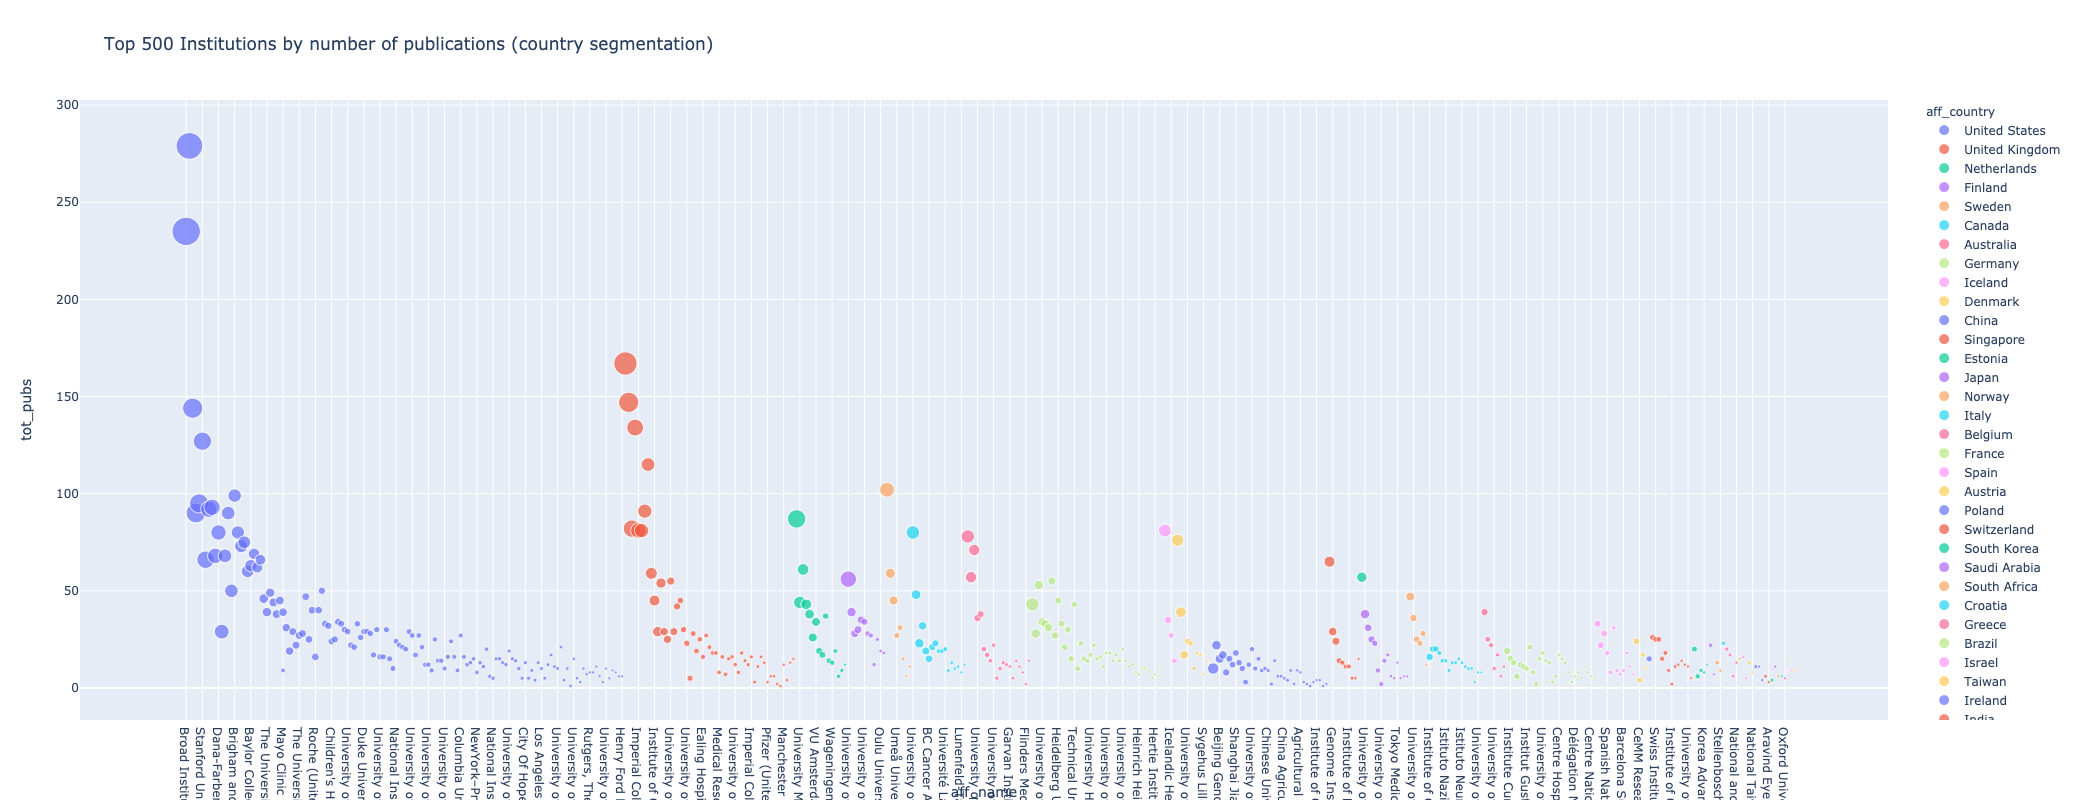

In [9]:
treshold = 500

px.scatter(gridaffiliations[:treshold], 
           x="aff_name", y="tot_pubs", 
           color="aff_country", 
           size='tot_affiliations',
           hover_name="aff_name", 
           height=800,
           hover_data=['aff_id', 'aff_name', 'aff_city', 'aff_country', 'tot_affiliations', 'tot_pubs'], 
           title=f"Top {treshold} Institutions by number of publications (country segmentation)")

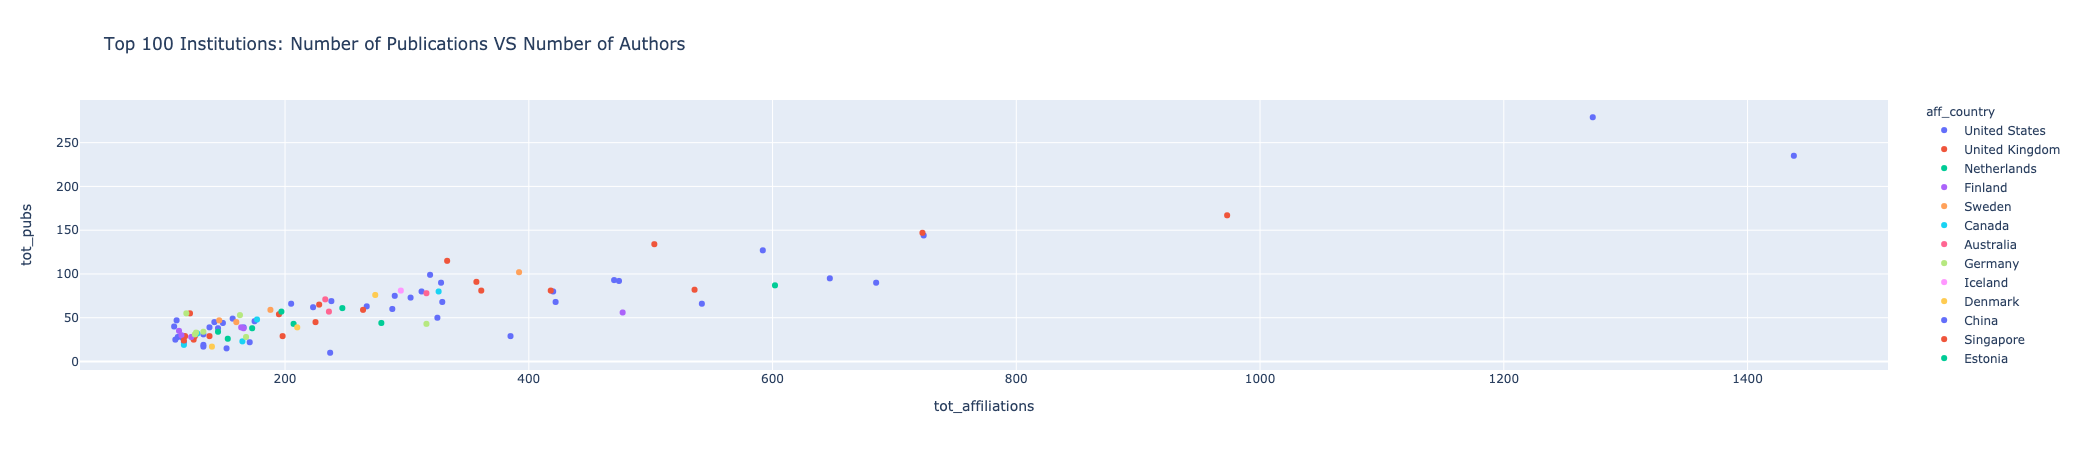

In [10]:
treshold = 100

px.scatter(gridaffiliations[:treshold], 
           x="tot_affiliations", y="tot_pubs", 
           color="aff_country",
           hover_name="aff_name", 
           hover_data=['aff_id', 'aff_name', 'aff_city', 'aff_country', 'tot_affiliations', 'tot_pubs'], 
           title=f"Top {treshold} Institutions: Number of Publications VS Number of Authors")